In [2]:
import torch
from denoising_diffusion_pytorch import *
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import ast

In [5]:
!nvidia-smi

Tue May 16 16:29:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    32W /  70W |    581MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install torch torchvision numpy matplotlib einops ema_pytorch accelerate pytorch_fid

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 9.1 MB/s eta 0:00:00


## Load the data

In [4]:
df_norm = pd.read_csv('data_norm.csv')

In [5]:
df_norm.shape

(32, 1280)

In [6]:
df_norm.iloc[0,0]

'[0.4485464836863576, 0.23743089577886559, 0.2567182871303501, 0.1354850899063267, 0.18036478413750115, 0.4131823404699217, 0.08743186116629063, 0.08291411727908572]'

In [7]:
ast.literal_eval(df_norm.iloc[:,0].values[1])

[0.4376705502296044,
 0.254018240277233,
 0.2693243020354921,
 0.3298455111797974,
 0.1166046458272751,
 0.2929268698042495,
 0.03417741251007273,
 0.04475562831666286]

In [50]:
# Convert strings to lists
list_array = np.array([ast.literal_eval(string) for string in df_norm.iloc[:,0]])
list_array

array([[0.44854648, 0.25671829, 0.18036478, 0.08743186],
       [0.43767055, 0.2693243 , 0.11660465, 0.03417741],
       [0.43305115, 0.2658135 , 0.0820547 , 0.03515119],
       [0.37406238, 0.16097329, 0.10682097, 0.03861371],
       [0.33136929, 0.17475936, 0.03357365, 0.03789614],
       [0.33137038, 0.27871445, 0.0861643 , 0.05857948],
       [0.33796216, 0.48085898, 0.09555173, 0.0525679 ],
       [0.32646167, 0.16471522, 0.19852092, 0.18221539],
       [0.27670095, 0.44620128, 0.1837161 , 0.11795196],
       [0.14597027, 0.3200988 , 0.36063414, 0.07436813],
       [0.3486953 , 0.26385395, 0.31903695, 0.27999776],
       [0.3420077 , 0.3538039 , 0.32024351, 0.35170195],
       [0.35832377, 0.24672675, 0.39716886, 0.57342063],
       [0.46717204, 0.29873028, 0.57069158, 0.74588335],
       [0.48421294, 0.32432361, 0.31692868, 0.30264252],
       [0.37454687, 0.28144074, 0.67328134, 0.1316115 ],
       [0.38814218, 0.12327163, 0.27478092, 0.14416161],
       [0.30003663, 0.2476862 ,

In [8]:
!mkdir images
counter = 0
for i in range(880):
      list_array = np.array([ast.literal_eval(string) for string in df_norm.iloc[:,i]])
      values = np.concatenate(list_array, axis=0).reshape(32, 8)
      tra = np.multiply(values, 255).astype(np.uint8)
      img = Image.fromarray(tra.T)
      img.save("images/train"+str(counter)+".png")
      counter = counter +1

In [9]:
counter

880

----

In [13]:
list_array = np.array([ast.literal_eval(string) for string in df_norm.iloc[:,0]])
values = np.concatenate(list_array, axis=0).reshape(32, 4)
print("1 ",values.shape)
tra = np.multiply(values, 255).astype(np.uint8)
print("2 ",tra.shape)
img = Image.fromarray(tra.T)
img.size

1  (32, 4)
2  (32, 4)


(32, 4)

In [11]:
test = Image.open("images12/train0.png")
test.size

(32, 4)

In [ ]:
trainer.load(2)

loading from version 1.5.6


In [ ]:

trainer.train()

100%|##########| 2000/2000 [00:00<?, ?it/s]

training complete


In [13]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels = 1
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = (32,8),
    timesteps = 1000,           # number of steps
    sampling_timesteps = 250,   # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
    loss_type = 'l2'            # L1 or L2
).cuda()

trainer = Trainer(
    diffusion,
    'images/',
    train_batch_size = 32,
    train_lr = 8e-5,
    train_num_steps = 12000,         # total training steps
    gradient_accumulate_every = 2,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    amp = False,                       # turn on mixed precision
    calculate_fid = True              # whether to calculate fid during training
)
#trainer.load(9)
trainer.train()

  0%|          | 0/12000 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.4703507423400879


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.5359463691711426


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.3748365640640259


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.470261812210083


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.39433348178863525


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.44206202030181885


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.28884029388427734


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.44584786891937256


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.3827829360961914


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.33300089836120605


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.431060791015625


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

fid_score: 0.560091495513916
training complete


In [14]:
for i in range(30):
    sampled_images = diffusion.sample(batch_size = 128)
    torch.save(sampled_images,'sampled_fft_12000_128_'+str(i))
    print("Finished Sample: ",i)

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  0


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  1


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  2


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  3


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  4


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  5


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  6


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  7


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  8


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  9


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  10


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  11


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  12


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  13


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  14


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  15


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  16


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  17


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  18


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  19


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  20


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  21


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  22


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  23


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  24


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  25


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  26


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  27


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  28


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Finished Sample:  29


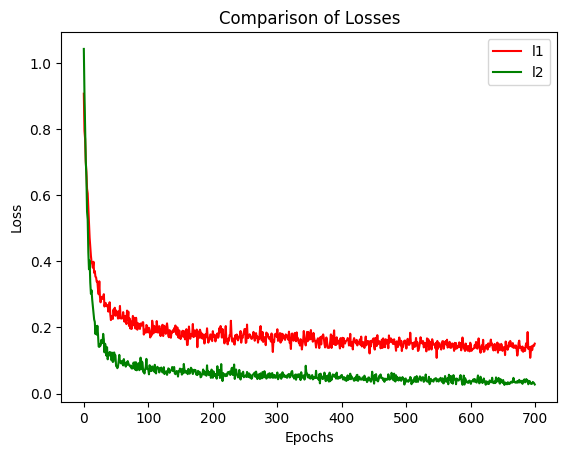

In [6]:
# Plotting both the curves simultaneously
plt.plot(lossesl1, color='r', label='l1')
plt.plot(lossesl2, color='g', label='l2')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Comparison of Losses")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.savefig('loss_comparison.png')
plt.show()